In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib
import imgaug.augmenters.contrast as iaa
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
from segmentation_models.metrics import iou_score

Segmentation Models: using `tf.keras` framework.


# Data preparation

In [58]:
images = list(Path(os.path.join('../data/unet/lung_segmentation/CXR_png/img')).glob('**/*'))
masks = list(Path(os.path.join('../data/unet/lung_segmentation/masks/img')).glob('**/*'))

In [59]:
print("Amount of images: ", len(images))
print("Amount of masks: ", len(masks))

Amount of images:  800
Amount of masks:  704


In [60]:
img_mask_tuples = []

for mask_path in masks:
    for i in images:
        basename = (os.path.basename(i)).split(".")[0]
        if basename in str(mask_path):
            img_path = i
            break
    img_mask_tuples.append((str(img_path), str(mask_path)))

In [61]:
len(img_mask_tuples)

704

## Plot images and masks

In [62]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

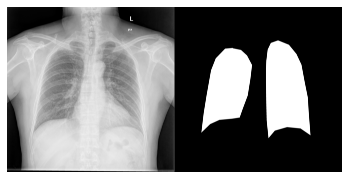

In [63]:
plot_img(img_mask_tuples[1])

In [64]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

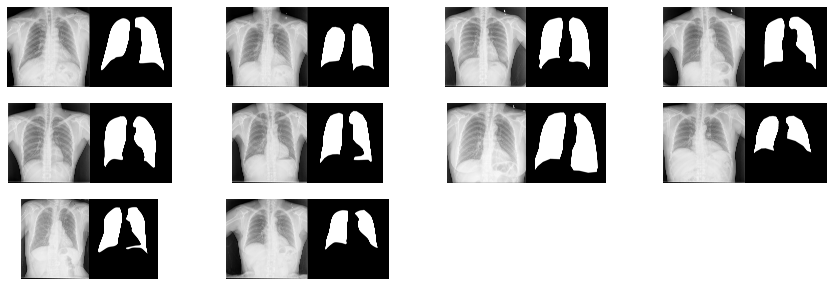

In [65]:
plot_img_matrix(img_mask_tuples[:10], 4)

In [66]:
df = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])
df_train = df.sample(frac=0.8, random_state=200)
df_val = df.drop(df_train.index)

df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

## UNET

In [55]:
IMG_SIZE = 256
BATCH_SIZE = 8

In [68]:
# https://github.com/aleju/imgaug/issues/66#issuecomment-387609992
# ToDo: Fine-tune params, especially gain. cutoff should remain close to 1, 5 <= gain < 20 
sigm_aug = iaa.SigmoidContrast(gain=(10, 10), cutoff=(0.8, 0.8))

In [69]:
def applySigmoidContrast(img):
    img = sigm_aug.augment_image(img)
    return img

In [70]:
def binarize_mask(img):
    # specify a threshold 0-255
    threshold = 255 // 2
    # make all pixels < threshold black
    return 1.0 * (img > threshold)

In [71]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, shuffle=True, applySigmoidAug=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.applySigmoidAug = applySigmoidAug

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X_img, X_mask = self.__get_data(batch)
        return np.array(X_img), np.array(X_mask)

    def on_epoch_end(self):
        # Todo: Fix?
        # self.indexes = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.indices)    

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]
            # normalize / rescale

            img = img / 255.0
            mask = mask / 255.0

            # ToDo: use imgaug Sequence and do this for the batch 
            if (self.applySigmoidAug):
                img = applySigmoidContrast(img)

            X_imgs.append(img)
            X_masks.append(mask)

        return X_imgs, X_masks

In [72]:
train_generator = DataGenerator(df_train, applySigmoidAug=False)
val_generator = DataGenerator(df_val, applySigmoidAug=False)

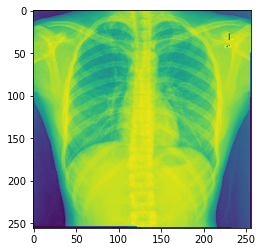

In [73]:
plt.imshow(train_generator.__getitem__(0)[0][2,:,:])

In [12]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [9]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [80]:
model = unet()
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=2e-4),
    # loss=sm.losses.dice_loss,
    loss='binary_crossentropy',
    # loss=sm.losses.bce_dice_loss,
    metrics=['binary_accuracy', iou_score]
)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_73[0][0]                  
_______________________________________________________________________________________

In [81]:
mcp_save = ModelCheckpoint('../models/unet_2708.h5', save_best_only=True, monitor='val_iou_score', mode='max')
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score', min_delta=0, patience=2, verbose=0, mode='max'
)

In [ ]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=15,
                    callbacks=[es, mcp_save])

In [15]:
# model = tf.keras.models.load_model('../models/unet_2708.h5', compile=False)

In [86]:
def get_pred_generator(img_list):
    df = pd.DataFrame(img_list, dtype='str', columns=['img'])
    return ImageDataGenerator().flow_from_dataframe(
        dataframe=df,
        x_col='img',
        directory=None,
        target_size=(IMG_SIZE, IMG_SIZE),
        class_mode=None,
        color_mode='grayscale',
        batch_size=8
    )

In [106]:
def pred_and_save_masks(in_path, out_path):
    images = list(Path(os.path.join(in_path)).glob('**/*'))
    pred = model.predict(get_pred_generator(images), batch_size=8)

    # now save our pred as images
    for i in range(0,len(pred)):
        org_img = str(images[i])
        pred_mask_name = os.path.basename(org_img).split('.')[0] + '_predmask.jpg'
        # mask = binarize_mask(pred_masks[i] * 255)
        plt.imsave(out_path + pred_mask_name, pred[i][:,:,0], cmap='gray')

In [107]:
pred_and_save_masks('../data/chest-x-ray/train/NORMAL/', '../data/chest-x-ray/masks/train/NORMAL/')

Found 1341 validated image filenames.


In [108]:
pred_and_save_masks('../data/chest-x-ray/train/PNEUMONIA/', '../data/chest-x-ray/masks/train/PNEUMONIA/')

Found 3875 validated image filenames.


In [109]:
pred_and_save_masks('../data/chest-x-ray/val/NORMAL/', '../data/chest-x-ray/masks/val/NORMAL/')

Found 8 validated image filenames.


In [110]:
pred_and_save_masks('../data/chest-x-ray/val/PNEUMONIA/', '../data/chest-x-ray/masks/val/PNEUMONIA/')

Found 8 validated image filenames.
